# Notebook basé sur l'utilisation de ipyleaflet
Charge les données de pluie Badoplu de 1960 à 2016 sur 36 stations
(données stockées dans daily_rain.csv et metadata.csv)

In [1]:
import numpy as np
import pandas as pd

import os
import json
import random
import requests
import pandas as pd
from ipyleaflet import Map, GeoJSON, Marker, CircleMarker, DrawControl, ScaleControl, Rectangle, DivIcon
import ipywidgets as ipyw
from pandas.io.json import json_normalize
import CacatoesUtils
import PluvioSahelUtils
from ipywidgets import HTML
import proplot as pplot



Nb : La cellule suivante doit être exécutée séparément sinon "erreur invalid syntaxe"

In [2]:
%%html
<style>
.leaflet-div-icon { color: red; font-weight:bold; background-color: transparent; border-color: transparent }
</style>

"df_to_geojson" permet de créer un geojson affichable avec ipyleaflet à partir du DataFrame des métadonnées Badoplu

In [3]:
def df_to_geojson(df, lat='latitude', lon='longitude'):
    # create a new python dict to contain our geojson data, using geojson format
    geojson = {'type':'FeatureCollection', 'features':[]}

    # loop through each row in the dataframe and convert each row to geojson format
    r = 0
    for _, row in df.iterrows():
        # create a feature template to fill in
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}

        # fill in the coordinates
        feature['geometry']['coordinates'] = [row[lon],row[lat]]
        feature['properties']['name'] = df.index[r]
        feature['properties']['selected'] = False
        r = r+1
        # add this feature (aka, converted dataframe row) to the list of features inside our dict
        geojson['features'].append(feature)
    
    return geojson

Chargement des données Badoplu

In [4]:
BadopluRain_1960_2016 = pd.read_csv('daily_rain.csv',parse_dates=True, index_col=0)
BadopluRain_1960_2016_Metadata = pd.read_csv('metadata.csv',index_col=0)
listStation = BadopluRain_1960_2016_Metadata.index
geojson = df_to_geojson(BadopluRain_1960_2016_Metadata, 'lat', 'lon')

In [5]:
#Variables Cacatoès "brutes"
variablesDictionary = {}
variablesDictionary[0] = 'DAILYmcs_Pop'
variablesDictionary[1] = 'QCmcs_Label'
variablesDictionary[2] = 'INT_Distance'
variablesDictionary[3] = 'INT_Smax_235K'
variablesDictionary[4] = 'INT_GridFraction_235K'
variablesDictionary[5] = 'INT_Smax_210K'
variablesDictionary[6] = 'INT_GridFraction_200K'
variablesDictionary[7] = 'INT_gridtimeOccupation_start'
variablesDictionary[8] = 'INT_gridtimeOccupation_end'
variablesDictionary[9] = 'INT_Duration'
variablesDictionary[10] = 'INIT_Time'
variablesDictionary[11] = 'END_Time'
variablesDictionary[12] = 'INT_Tmax'
variablesDictionary[13] = 'INT_Sfract_210K'
variablesDictionary[14] = 'INT_Tbmin'

#Indices construits à partir des variables Cacatoès et que l'on souhaite représenter en fonction des pluies
wantedIndice = {}
wantedIndice[0] = 'NB MCS'
wantedIndice[1] = 'Fraction cell index 235K'
wantedIndice[2] = 'Fraction cell index 200K'
wantedIndice[3] = 'Distance MCS index'
wantedIndice[4] = 'Smax 235 index'
wantedIndice[5] = 'Smax 210 index'
wantedIndice[6] = 'Durée sur cellule'
wantedIndice[7] = 'Distance à Tmax index'
wantedIndice[8] = 'Durée sur cellule autour Tmax'
wantedIndice[9] = 'Temp brightness mini'
wantedIndice[10] = 'Fraction MCS 210K x durée dans maille'

#Les villes les cellules "Cacatoes" les années sont choisis dans l'interface ipyleaflet
villesDictionary = {}
cells = {}
anneesDict = {}

#Dictionnaires pour stocker les résultats
DataPluie = {}
Plots = {}
MaxValues = {}

## Code pour IHM ipyleaflet !
#### Une fois la cellule exécutée:
#### Choisir les villes avec l'outil "rectangle" dans la barre de gauche
#### Choisir les années
#### Choisir le seuil pluvio "plancher"
#### Choisir le seuil pluvio "plafond" (1000 pour pas de plafond par ex.)
#### Cliquer sur "GO" => attendre que la barre de progression se remplisse
#### Cliquer sur "Clear datas" pour effacer et faire un autre essai

In [10]:
selectedCells = {}

def handle_click(**kwargs):
    print(kwargs)
    name=kwargs['feature']['properties']['name']
    selected=kwargs['feature']['properties']['selected']
    print(kwargs['feature']['properties']['selected'])
    if selected==True:
        selected=False
        print('passage a false')
    else:
        print('passage dans else')
        selected=True
    kwargs['feature']['properties']['selected']=selected
    message = name + ' :selected=' + str(kwargs['feature']['properties']['selected'])
    print(kwargs['feature'])
    geo_json.point_style ={'color': 'green'}
    #kwargs['feature'].point_style={'color': 'green'}

def handle_draw(target, action, geo_json):
    print(action)
    print(target.data)
    

def random_color(feature):
    return {
        'color': 'black',
        'fillColor': random.choice(['red', 'yellow', 'green', 'orange']),
    }

m = Map(center=(10, 0), zoom=4, scroll_wheel_zoom=True)

button = ipyw.Button(description="GO !")
def on_button_clicked(b):
    
    for i in np.arange(len(selectyears.value)):
        anneesDict[i] = int(selectyears.value[i])
    data = draw_control.data[0]
    minCorner = data['geometry']['coordinates'][0][0]
    maxCorner = data['geometry']['coordinates'][0][2]
    minLonSelected = minCorner[0]
    maxLonSelected = maxCorner[0]
    minLatSelected = minCorner[1]
    maxLatSelected = maxCorner[1]
    lonLim = [minLonSelected,maxLonSelected]
    latLim = [minLatSelected,maxLatSelected]
    zoneLim = [lonLim,latLim]
    selectedMetadata, selectedDataRain = PluvioSahelUtils.StationFilter(BadopluRain_1960_2016, BadopluRain_1960_2016_Metadata, zoneLim)
    listStation = selectedMetadata.index
    for i in np.arange(len(listStation)):
        villesDictionary[i] = listStation[i]
    for ville in villesDictionary.values():
        cells[ville] = CacatoesUtils.getCellForStation(BadopluRain_1960_2016_Metadata, ville)
    c = 0
    for ville in villesDictionary.values():
        lonmin = cells[ville][0][0]
        lonmax = cells[ville][0][1]
        latmin = cells[ville][1][0]
        latmax = cells[ville][1][1]
        rectangle = Rectangle(bounds=((latmin, lonmin), (latmax, lonmax)))
        m.add_layer(rectangle)
        selectedCells[c] = rectangle
        c+=1
    
    needCheckVeille = True
    seuilPluvioMax = float(selectSeuil.value)
    maxPluvioAbsolu = int(selectMaxValue.value)
    maxNBMCS_totake = 25
    maxNBMCS_forIndice = 1
    minStd = 0.0
    maxStd = 1000
    givePrevAndNextDay = False
    seuilWithMoyenne = True
    pathFilesCacatoes = '../CACATOES/AMMA-CATCH/'
    t1, t2, t3, t4 = CacatoesUtils.ComputePlotData_Sahel_Cacatoes(BadopluRain_1960_2016, villesDictionary, cells, variablesDictionary, 
                                                              wantedIndice, seuilPluvioMax, maxPluvioAbsolu, anneesDict, progress, needCheckVeille, 
                                                              maxNBMCS_totake,maxNBMCS_forIndice,minStd, maxStd, givePrevAndNextDay, seuilWithMoyenne,
                                                              pathFilesCacatoes)
    #t1, t2, t3 = CacatoesUtils.ComputePlotData_Sahel_Cacatoes(testLoad, villesDictionary, cells, variablesDictionary, 
    #                                                          wantedIndice, seuil, maxValue, anneesDict,progress)
    for indice in wantedIndice.values():
        Plots[indice] = t2[indice]
        MaxValues[indice] = t3[indice]
    DataPluie['Pluie'] = t1['pluie max']
    DataPluie['Ville'] = t1['Ville']
    progress.value = 100
    
def on_clear_clicked(b):
    draw_control.clear()
    for cell in selectedCells.values():
        m.remove_layer(cell)
    selectedCells.clear()
    selectSeuil.value = ''
    selectMaxValue.value = ''
    progress.value = 0
    selectyears.value = []
    villesDictionary.clear()
    cells.clear()
    anneesDict.clear()
    DataPluie.clear()
    Plots.clear()
    MaxValues.clear()

button.on_click(on_button_clicked)
buttonClear = ipyw.Button(description="Clear datas")
buttonClear.on_click(on_clear_clicked)
#output = widgets.Output()
var = 0
geo_json = GeoJSON(
    data=geojson, point_style={'color': 'red'},
    hover_style={'color': 'white', 'dashArray': '0', 'fillOpacity': 0.5},
    #style_callback=random_color
)
w, h = 32, 32

for v in np.arange(len(BadopluRain_1960_2016_Metadata)):
    html = BadopluRain_1960_2016_Metadata.index[v]
    #html = f'<img src="https://simpleicons.org/icons/apple.svg" width="{w}" height="{h}"/>'
    icon = DivIcon(html=html, bg_pos=(0, 0), icon_size=[w, h])
    loc = (BadopluRain_1960_2016_Metadata['lat'][v], BadopluRain_1960_2016_Metadata['lon'][v]+0.3)
    mark = Marker(location=loc, icon=icon, draggable=True)
    m.add_layer(mark)



draw_control = DrawControl()
draw_control.rectangle = {
    "shapeOptions": {
        "fillColor": "#fca45d",
        "color": "#fca45d",
        "fillOpacity": 0.3
    }
}
geo_json.on_click(handle_click)
#geo_json.on_hover(hover_handler)

progress = ipyw.IntProgress(
    value=0,
    min=0,
    max=100,
    description='Progression:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': 'maroon'},
    orientation='horizontal'
)
#options=['2015','2007', '2008', '2009','2010','2011','2012','2013','2014','2015'],
listPossibleYears = []
for y in np.arange(1989, 2017,1):
    year = str(int(y))
    listPossibleYears.append(year)
selectyears = ipyw.SelectMultiple(
    options=listPossibleYears,
    value=['2007'],
    description='Annees',
    disabled=False
)

selectSeuil = ipyw.Text(
    value='',
    placeholder='valeur en mm',
    description='Seuil pluvio:',
    layout=ipyw.Layout(width='250px'),
    disabled=False)

selectMaxValue = ipyw.Text(
    value='',
    placeholder='valeur entière en mm',
    description='Max pluvio:',
    layout=ipyw.Layout(width='250px'),
    disabled=False)

m.add_layer(geo_json)
m.add_control(draw_control)
m.add_control(ScaleControl(position='bottomleft'))
ipyw.VBox([m, ipyw.HBox([selectyears,selectSeuil,selectMaxValue]),ipyw.HBox([button,progress,buttonClear])])

### Plot des valeurs d'incides en fonction de la pluie
1 graphe par indice !

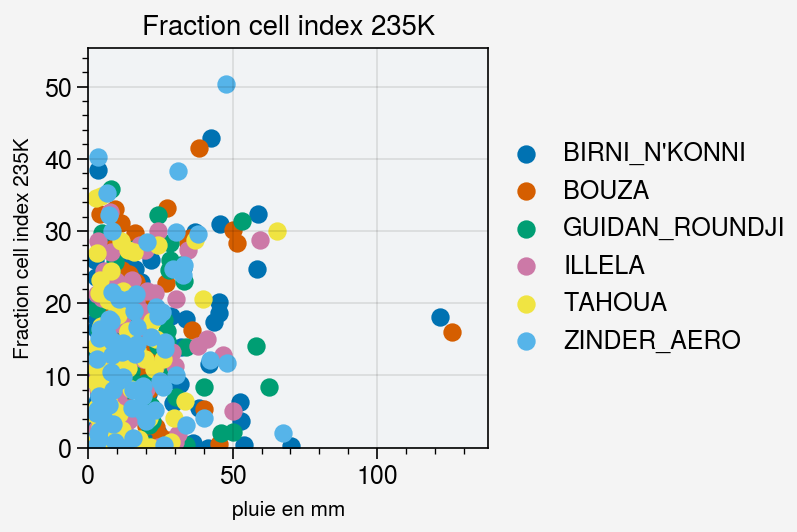

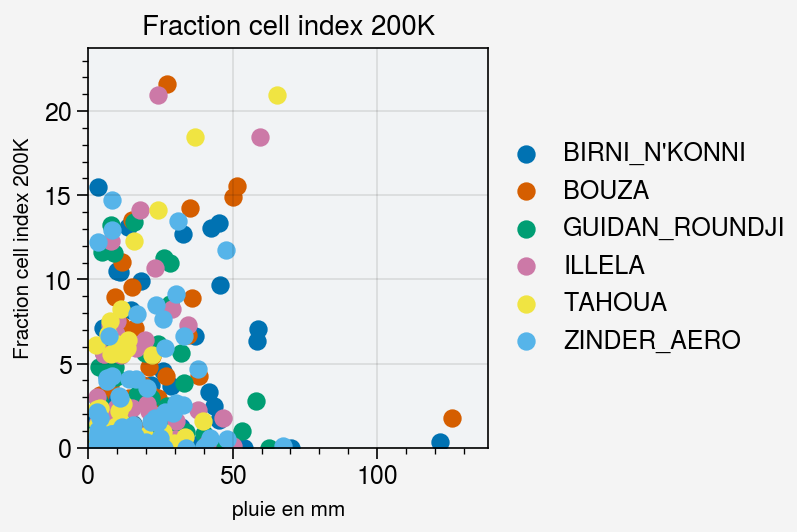

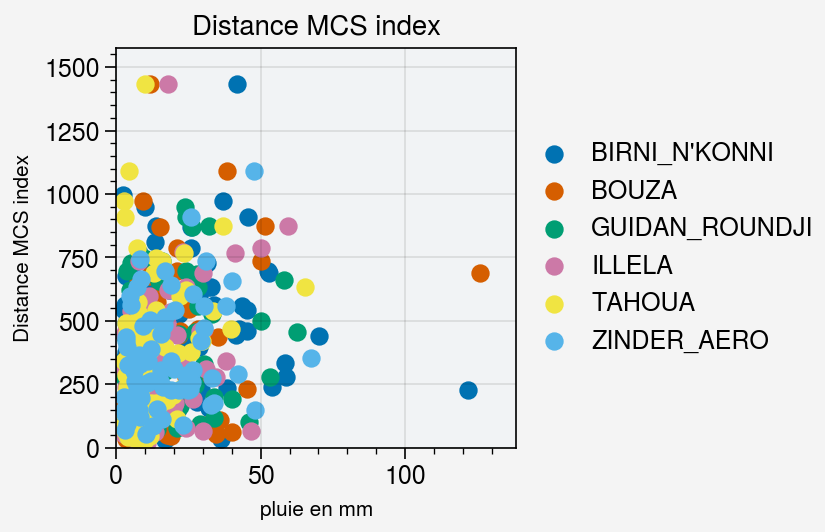

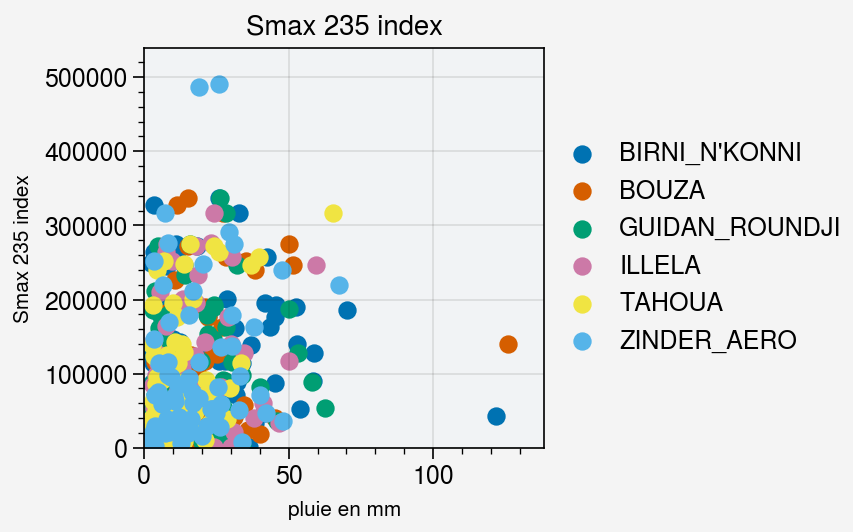

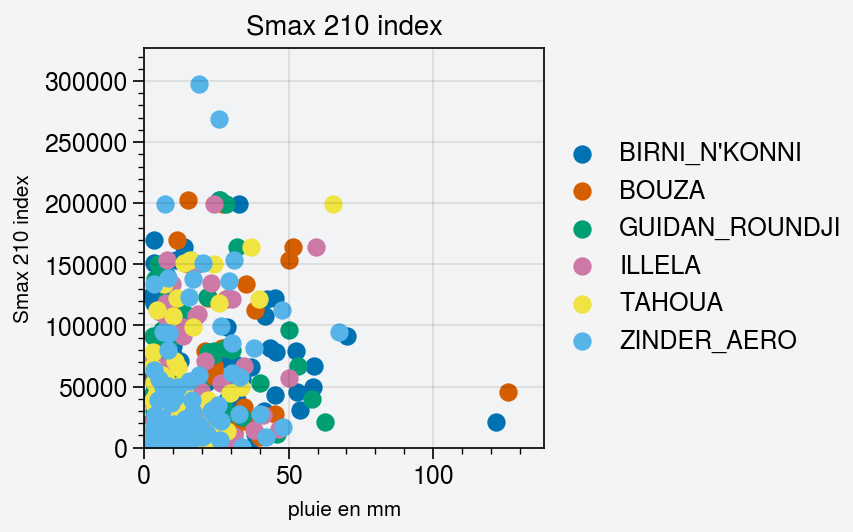

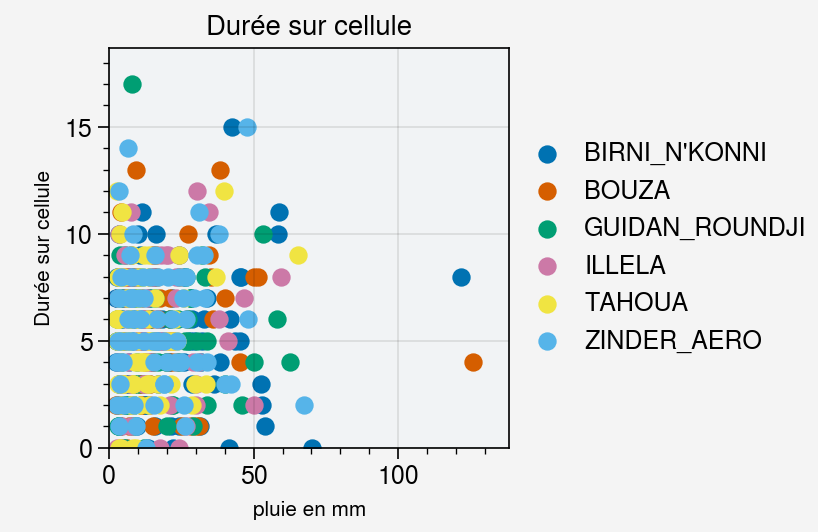

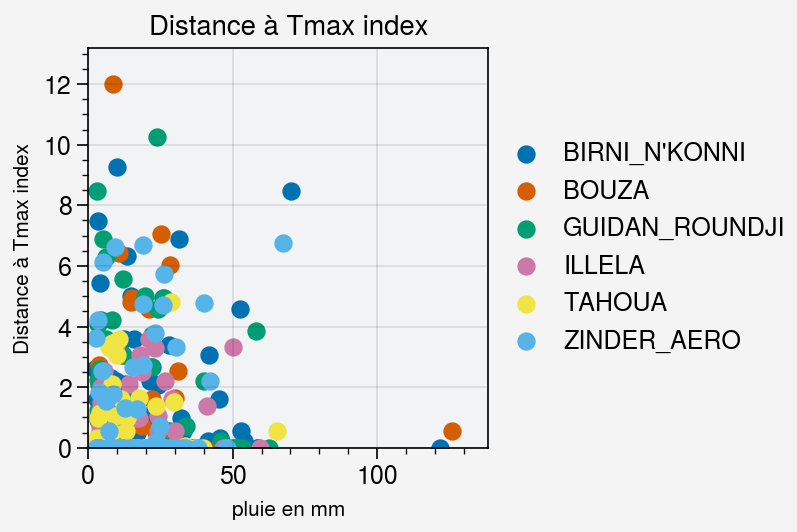

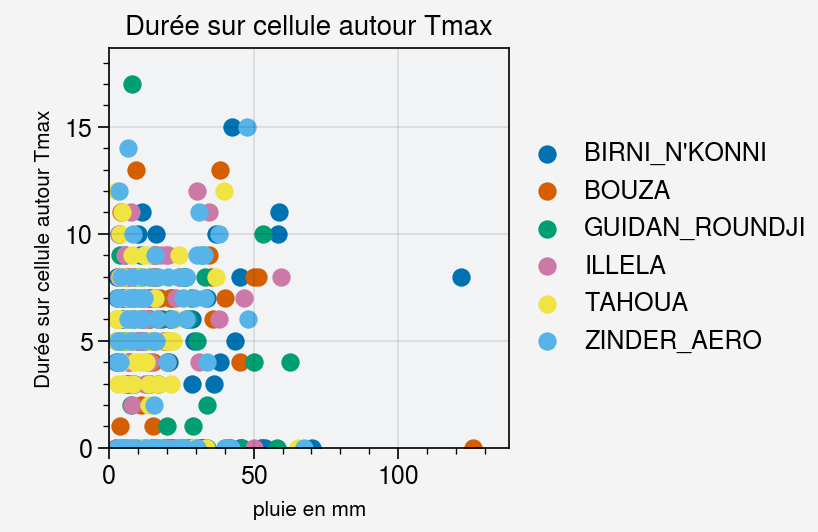

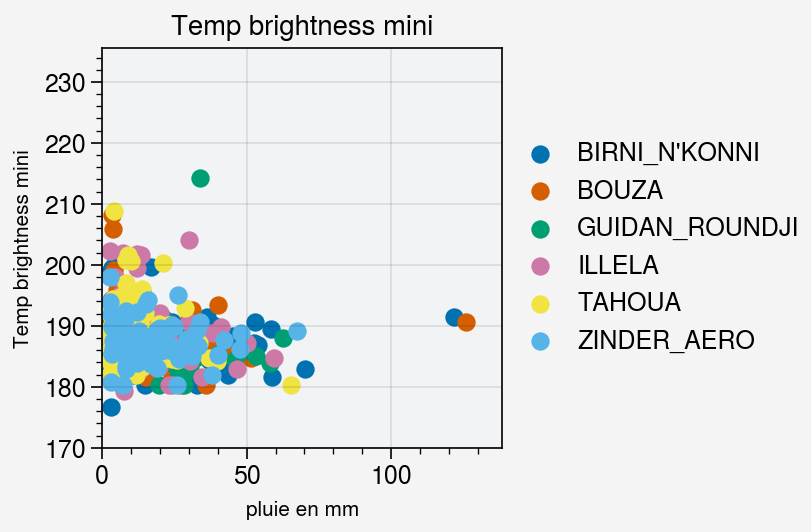

In [11]:
#graphes multiples
colors = ['blue7', 'red7', 'green7', 'yellow7']
pplot.rc.abc = False
k = 0
minPluie = 0
maxPluie = 1.1 * np.max(DataPluie['Pluie'])
for key in Plots:
    gs = pplot.GridSpec(nrows=1, ncols=1)
    fig = pplot.figure(axwidth=2, axheight=2, share=False)
    iCol = k%4
    
    ax = fig.subplot(gs[0,0])
    k = k+1
    #MaxValue[key] = 1.1 * np.max(Plots[key])
    #ax.bar(list_annees, annual_index_cr,color='tan',label='Extrêmes annuels')
    seriePluie = DataPluie['Pluie']
    serieVille = DataPluie['Ville']
    for ville in villesDictionary.values():
        index = np.where(DataPluie['Ville'] == ville)
        ax.scatter(DataPluie['Pluie'][index[0]],Plots[key][index[0]], label = ville)
    
    if key == 'Temp brightness mini':
        ax.format(title=key,fc='gray1', xlabel='pluie en mm',ylabel=key,labelsize='small',xlim=[minPluie,maxPluie],ylim=[170,MaxValues[key]])
    else:
        ax.format(title=key,fc='gray1', xlabel='pluie en mm',ylabel=key,labelsize='small',xlim=[minPluie,maxPluie],ylim=[0,MaxValues[key]])
    ax.legend(loc='r', ncols=1, frame=False)

## Tendance sur les pluies 

construction indice sur  6  stations
Index(['BIRNI_N'KONNI', 'BOUZA', 'GUIDAN_ROUNDJI', 'ILLELA', 'TAHOUA',
       'ZINDER_AERO'],
      dtype='object')


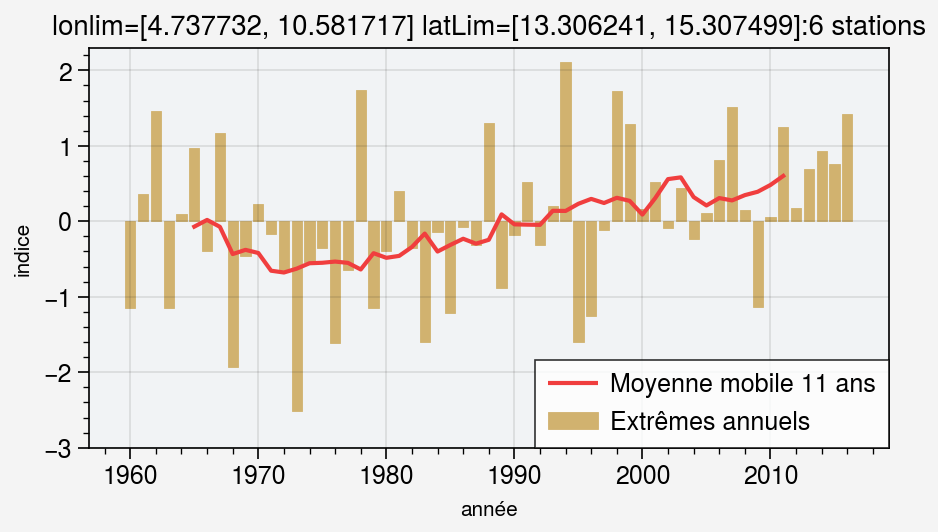

In [12]:
pplot.rc.abc = False
fig = pplot.figure(refaspect=2, axwidth=4, axheight=2, share=False)
nb = 0
for d in draw_control.data:
    nb = nb+1
gs = pplot.GridSpec(nrows=nb, ncols=1)
i = 0
for d in draw_control.data:
    minCorner = draw_control.data[i]['geometry']['coordinates'][0][0]
    maxCorner = draw_control.data[i]['geometry']['coordinates'][0][2]
    

    minLonSelected = minCorner[0]
    maxLonSelected = maxCorner[0]
    minLatSelected = minCorner[1]
    maxLatSelected = maxCorner[1]
    lonLim = [minLonSelected,maxLonSelected]
    latLim = [minLatSelected,maxLatSelected]

    zoneLim = [lonLim,latLim]
    annual_index, listStation, list_annees = PluvioSahelUtils.BuildAnnualIndex(BadopluRain_1960_2016, BadopluRain_1960_2016_Metadata, 1960, 2016, zoneLim)
    mean_annual_index = np.nanmean(annual_index)
    std_annual_index = np.nanstd(annual_index)
    annual_index_cr = (annual_index - mean_annual_index) / std_annual_index
    moyenne_mobile = PluvioSahelUtils.moving_average_withsamedimension(annual_index_cr,11)
    ax = fig.subplot(gs[i,0])
    i=i+1
    titre = 'lonlim='+str(lonLim)+' latLim='+str(latLim) + ':'+str(listStation.size)+ ' stations'
    ax.bar(list_annees, annual_index_cr,color='tan',label='Extrêmes annuels')
    ax.plot(list_annees, moyenne_mobile,color='red7',label='Moyenne mobile 11 ans')
    ax.format(title=titre,fc='gray1', xlabel='année',ylabel='indice',labelsize='small',ylim=[-3,2.3])

    ax.legend(ncols=1)